In [360]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [361]:
import os
import subprocess
import io
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toml
from tqdm.auto import tqdm
from markovids import pcl, vid, depth

In [362]:
import h5py

## User functions

In [363]:
def lp_filter(x, sigma):
    return cv2.GaussianBlur(x, [0, 0], sigma, sigma)

def bp_filter(x, sigma1, sigma2, clip=True):
    if (sigma1 == 0) or (sigma1 is None):
        return x
    elif (sigma2 == 0) or (sigma2 is None):
        return lp_filter(x, sigma1)
    else:
        return np.clip(
            lp_filter(x, sigma1) - lp_filter(x, sigma2),
            0 if clip == True else -np.inf,
            np.inf,
        )

In [364]:
# https://stackoverflow.com/questions/52498777/apply-matplotlib-or-custom-colormap-to-opencv-image
def mpl_to_cv2_colormap(cmap_name):
    import matplotlib.pyplot as plt

    cmap = plt.get_cmap(cmap_name)
    sm = plt.cm.ScalarMappable(cmap=cmap)

    # step from min to max, strip alpha, rgb to bgr
    color_range = sm.to_rgba(np.linspace(0, 1, 256), bytes=True)[:, 2::-1]
    return color_range.reshape(256, 1, 3)

def minmax_scale(batch_frames):
    use_min = batch_frames.min(axis=(1,2), keepdims=True)
    use_max = batch_frames.max(axis=(1,2), keepdims=True)
    
    # normalize between 0-1
    batch_frames = (batch_frames - use_min) / (use_max - use_min) 
    batch_frames[batch_frames<0] = 0
    batch_frames[batch_frames>1] = 1
    return batch_frames

def intensity_to_rgba(frame, minval=1800, maxval=2200, colormap=cv2.COLORMAP_TURBO):
    disp_frame = frame.copy().astype("float")
    disp_frame -= minval
    disp_frame[disp_frame < 0] = 0
    disp_frame /= np.abs(maxval - minval)
    disp_frame[disp_frame >= 1] = 1
    disp_frame *= 255
    bgr_frame = cv2.applyColorMap(disp_frame.astype(np.uint8), colormap)
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # new_frame[:, :, :3] = rgb_frame / 255.0
    return rgb_frame

# Load in metadata

In [365]:
# base_dir = "/mnt/data/jmarkow/projects_active/mouse_open_field_multicam_lucid"
base_dir = "/home/jmarkow/data_dir/active_projects/quantum_dots/timecourse_02_joints/"
background_path = "_bground"
frame_path = "_proc"

In [366]:
calibration_data = toml.load("/home/jmarkow/data_dir/active_projects/quantum_dots/timecourse_02_calibration_v2.toml")
cameras = sorted(list(calibration_data["intrinsics"].keys()))

In [367]:
# camera_dirs = [os.path.join(base_dir, _camera) for _camera in cameras]

In [368]:
minval = 0
maxval = 255
use_cmap = plt.matplotlib.cm.turbo
use_cmap = mpl_to_cv2_colormap(use_cmap)

step_size = 15 # save every Nth frame from each video
pad = 0 # pad with a 20px border
dry_run = False
bpass = (3, 20)
weights = (.85, .15)

eps = 2
randomize_priority = True # randomize label order
use_camera_order = True

In [371]:
def get_data_info(dir, cameras=cameras):
    include_cameras = []
    for _cam in cameras:
        reflect_path = os.path.join(dir, frame_path, f"{cameras[0]}-reflectance.avi")
        if os.path.exists(reflect_path):
            include_cameras.append(_cam)
    
    reader = vid.io.AutoReader(reflect_path)
    nframes = reader.nframes
    return {"cameras": include_cameras, "nframes": nframes}

In [372]:
def load_data(dir, cameras=cameras, spacing=step_size):
    data = {}
    for _cam in cameras:
        data[_cam] = {}
        reflect_path = os.path.join(dir, frame_path, f"{_cam}-reflectance.avi")
        fluo_path = os.path.join(dir, frame_path, f"{_cam}-fluorescence.avi")
        reader = vid.io.AutoReader(reflect_path)
        nframes = reader.nframes
        frame_range = range(0, nframes, spacing)
        
        frames = reader.get_frames(frame_range) 
        reader.close()
        
        reader = vid.io.AutoReader(fluo_path)
        fluo_frames = reader.get_frames(frame_range) 
        reader.close()

        data[_cam]["reflect"] = frames
        data[_cam]["filepath_reflect"] = reflect_path
        
        use_bground_path = os.path.join(dir, frame_path, background_path, f"{_cam}-fluorescence.hdf5")
        with h5py.File(use_bground_path, "r") as f:
            rolling_bgrounds = f["bground"][()]
            idxs = f["frame_idxs"][()]
    
        for i, (_idx, _frame) in enumerate(zip(frame_range, fluo_frames)):
            use_bground = np.argmin(np.abs(idxs - _idx))
            fluo_frames[i] = np.clip(_frame - rolling_bgrounds[use_bground], 0, 255).astype("uint8")

        data[_cam]["fluo"] = fluo_frames
        data[_cam]["filepath_fluo"] = fluo_path
        

    return data, frame_range

# Gather all data files

In [373]:
import glob
dat_paths = sorted(glob.glob(os.path.join(base_dir, "session*")))
dat_paths = [_ for _ in dat_paths if os.path.isdir(_)]

# Filter by metadata (if necessary)

In [374]:
# include subjects
exclude_subjects = ["qd_knee_01", "qd_knee_02"]
# include days
exclude_dates = pd.to_datetime(["2024-08-08", "2024-08-09"])
exclude_paths = []
for _path in dat_paths:
    metadata = toml.load(os.path.join(_path, "metadata.toml"))
    subject = metadata["user_input"]["subject"].lower()
    start_time = pd.to_datetime(metadata["start_time"]).floor("d")
    date_match = start_time in exclude_dates
    subject_match = subject in exclude_subjects
    if date_match or subject_match:
        exclude_paths.append(_path)

In [375]:
dat_paths = sorted(list(set(dat_paths) - set(exclude_paths)))

# Test on small dataset

In [309]:
spacing = 100

In [310]:
test_data, frame_range = load_data(dat_paths[0], spacing=spacing)

In [311]:
use_frame = 21

In [321]:
cnt = 0
for _camera in tqdm(cameras):
    for _frame in tqdm(test_data[_camera]["fluo"]):
        proc_fluo = bp_filter(_frame.astype("float32"), *bpass)
        proc_fluo[proc_fluo<=0]=0
        cnt += (proc_fluo.max() >= fluo_threshold)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

In [326]:
print(len(test_data[_camera]["fluo"]) * len(cameras))

435


In [327]:
print(cnt)

150


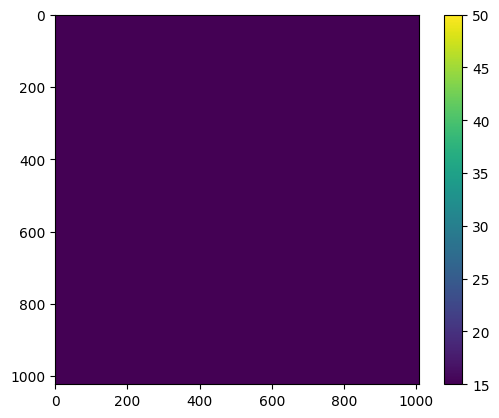

In [328]:
plt.imshow(proc_fluo, vmin=15, vmax=50)
plt.colorbar()

In [255]:
new_im = weights[0] * proc_fluo + weights[1] * test_data[cameras[3]]["reflect"][use_frame]
new_im = (new_im - new_im.min()) / (new_im.max() - new_im.min())
new_im *= 255
new_im = new_im.astype("uint8")

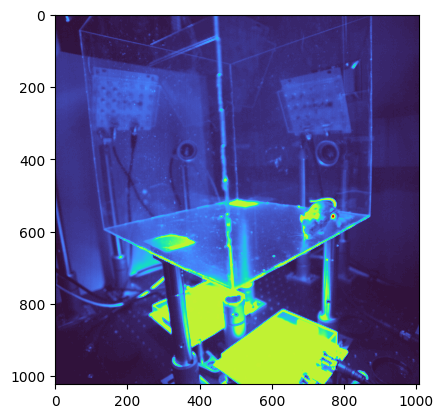

In [256]:
plt.imshow(new_im, cmap="turbo")

# Get what already exists on segments

In [378]:
from segments import SegmentsClient
import json

# You can find your api key at https://segments.ai/account
api_key = "XXX"
client = SegmentsClient(api_key)

In [379]:
dataset_name = "jmarkow/basler-nir-plexiglass-arena-keypoints-fused-kneejoints"

In [380]:
# dataset_name = "jmarkow/lucid-helios2plus-openfield-mouse-cables"
samples = client.get_samples(dataset_name)
filenames_uploaded = []
for _sample in samples:
    filenames_uploaded.append(os.path.basename(_sample.metadata["img_path"]))

In [381]:
filenames_uploaded

[]

# Export data to directory first

In [382]:
filenames_to_upload = []

In [383]:
fluo_threshold = 50
dry_run = False

In [384]:
export_dir = "/home/jmarkow/data_dir/active_projects/keypoints_basler_nir_plexiglass_arena/segments_ai_labeling_export_fused_kneejoints"

In [385]:
os.makedirs(export_dir, exist_ok=True)

In [386]:
from PIL import Image
from PIL.PngImagePlugin import PngInfo

In [387]:
dat_info = get_data_info(_path)    

In [388]:
use_cameras = dat_info["cameras"]
frame_range = range(0, dat_info["nframes"], step_size)

In [389]:
import warnings

In [390]:
filename_template = "{}_{}_{}.png"

In [391]:
for _path in tqdm(dat_paths):

    dat_info = get_data_info(_path)
    use_cameras = dat_info["cameras"]
    frame_range = range(0, dat_info["nframes"], step_size)
    
    fileparts = os.path.normpath(_path).split(os.path.sep)
    session_name = fileparts[-1].split(" ")[0]

    missing_files = []
    for _cam in use_cameras:
        for _idx in frame_range:
            missing_files.append(filename_template.format(session_name, _cam, _idx))
    # missing_files = [filename_template.format(session_name, fname, _idx) for _idx in read_frames]
    missing_files = [_file for _file in missing_files if not os.path.exists(os.path.join(export_dir, _file))]
    
    if len(missing_files) < 1:
        continue
    try:
        dat, frame_range = load_data(_path, spacing=step_size)
    except FileNotFoundError:
        warnings.warn(f"Error loading {_path}")
        continue
   
    for _cam in use_cameras:
        for _frame, _idx in enumerate(frame_range):
    
            # alright...
            proc_fluo = bp_filter(dat[_cam]["fluo"][_frame].astype("float32"), *bpass)
            proc_fluo[proc_fluo<=0]=0

            # INSERT FLUORESCENCE THRESHOLD HERE!
            if proc_fluo.max() < fluo_threshold:
                continue

            new_im = weights[0] * proc_fluo + weights[1] * dat[_cam]["reflect"][_frame]
            new_im = (new_im - new_im.min()) / (new_im.max() - new_im.min())
            new_im *= 255
            new_im = new_im.astype("uint8")
            
            # skip if filename is already in the directory...
            # NOTE that this should be unique, session_name is session (and host)
            # filename already includes camera
            # idx is frame number
            filename_export = os.path.join(export_dir, filename_template.format(session_name, _cam, _idx))
            filename_base = os.path.basename(filename_export)
            
            use_frame = np.pad(
                    new_im, ((pad, pad), (pad, pad)), mode="constant", constant_values=0
                )
            export_frame = intensity_to_rgba(
                use_frame, minval=minval, maxval=maxval, colormap=use_cmap
            )[:, :, :3]
            
            targetImage = Image.fromarray(export_frame)
            metadata = PngInfo()
            metadata.add_text("pad", str(pad))
            metadata.add_text("frame_index", str(_idx))
            metadata.add_text("camera", _cam)
            metadata.add_text("dat_path_fluo", dat[_cam]["filepath_fluo"])
            metadata.add_text("dat_path_reflect", dat[_cam]["filepath_reflect"])
            metadata.add_text("img_path", filename_export)

            if not dry_run:
                if not os.path.exists(filename_export):
                    targetImage.save(filename_export, pnginfo=metadata)

  0%|          | 0/1 [00:00<?, ?it/s]

In [392]:
filenames_exported = sorted(glob.glob(os.path.join(export_dir, "*.png")))

In [393]:
filenames_to_upload = [_fname for _fname in filenames_exported if os.path.basename(_fname) not in filenames_uploaded]

# Upload new data to segments.ai

In [394]:
print(len(filenames_to_upload))

1109


In [395]:
urls = []

In [396]:
for _filename in tqdm(filenames_to_upload):
    with open(_filename, "rb") as f:
        use_filename = os.path.basename(_filename)
        asset = client.upload_asset(f, use_filename)
    image_url = asset.url
    urls.append(image_url)

  0%|          | 0/1109 [00:00<?, ?it/s]

In [397]:
for _name, _url in tqdm(zip(filenames_to_upload, urls), total=len(filenames_to_upload)):
    # convert numeric metadata prior to adding to dataset...
    metadata = Image.open(_name).text
    metadata["pad"] = int(metadata["pad"])
    metadata["frame_index"] = int(metadata["frame_index"])
    attributes = {"image": {"url": _url}}
    sample = client.add_sample(dataset_name, os.path.basename(_name), attributes, metadata=metadata)

  0%|          | 0/1109 [00:00<?, ?it/s]

In [398]:
samples = client.get_samples(dataset_name, per_page=10000)

In [399]:
# group samples by camera, then permute (SAVE THE RANDOM SEED), use descending priority

In [400]:
samples_by_camera = {}
for _cam in cameras:
    samples_by_camera[_cam] = [_sample for _sample in samples if _sample.metadata["camera"] == _cam]

In [401]:
indices_by_camera = {}
rng = np.random.default_rng(seed=0)
for _cam in cameras:
    idx = np.arange(len(samples_by_camera[_cam]))
    idx = rng.permutation(idx)
    indices_by_camera[_cam] = idx


In [402]:
priority = len(samples)
frame_idx = range(len(samples_by_camera[_cam]))

In [403]:
for _idx in tqdm(frame_idx):
    for _cam in cameras:
        try:
            use_sample = samples_by_camera[_cam][_idx]
            client.update_sample(use_sample.uuid, priority=priority)
            priority -= 1
        except IndexError:
            continue

  0%|          | 0/209 [00:00<?, ?it/s]

IndexError: list index out of range